Validation:
 - Task 1 - R1 0.224875  | MRR  0.171651  | Precision  0.325939
 - Task 2 - R1 0.036856  | MRR  0.020306  | Precision  0.199269

Public Leaderboard:
 - Task 1: R1 - 0.234219  | MRR - 0.179605  | Precision - 0.336561
 - Task 2: R1 - 0.012731  | MRR - 0.006671  | Precision - 0.138875

In [ ]:
!mkdir data
!mkdir data/baseline_catboost

!wget https://storage.yandexcloud.net/datasouls-ods/materials/0433a4ca/transactions.zip -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/0554f0cf/clickstream.zip -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/acfacf11/train_matching.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b949c04c/mcc_codes.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/705abbab/click_categories.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/e33f2201/currency_rk.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b99fed70/puzzle.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/f76e8087/sample_submission.csv -P data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/24687252/baseline_catboost.zip -P data
    
!unzip data/transactions.zip -d data
!unzip data/clickstream.zip -d data
!unzip data/baseline_catboost.zip -d data/baseline_catboost

!rm data/transactions.zip
!rm data/clickstream.zip
!rm data/baseline_catboost.zip

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import pickle
from catboost import CatBoostClassifier
import catboost
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data, output_path = sys.argv[1:]
print(data)
print(output_path)

input_folder = 'data'

print(catboost.__version__, np.__version__, pd.__version__)

import multiprocessing
from psutil import virtual_memory
ram_gb = round(virtual_memory().total / 1024**3, 1)
print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)

def print_memory():
    print('memory used', round(virtual_memory().used/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available * 100 / virtual_memory().total,2), 'percent')

-f
/home/jovyan/.local/share/jupyter/runtime/kernel-eda7fbd4-b56b-44df-b57b-3a0c5f161ac9.json
1.0.4 1.22.2 1.4.1
CPU: 8
RAM GB: 31.4


In [18]:
all_dicts = {}

### 1. Clickstream

In [19]:
%%time
clickstream = pd.read_csv(f'{input_folder}/clickstream.csv')

print('clickstream memory usage: ', clickstream.memory_usage().sum()//1024//1024, 'Mb')
print_memory()

clickstream['timestamp'] = pd.to_datetime(clickstream['timestamp'])

clickstream memory usage:  3868 Mb
memory used 10.84 Gb | memory available 20.07 Gb | memory available 64.01 percent
CPU times: user 1min 34s, sys: 27 s, total: 2min 1s
Wall time: 2min 1s


In [20]:
print(clickstream.shape)
clickstream.head(2)

(126752515, 4)


,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448
1,000143baebad4467a23b98c918ccda19,165,2021-01-31 20:06:29,1873448


In [21]:
for col in clickstream:
    print(col, '\t', clickstream[col].nunique(), '\t', clickstream[col].min(), ' - ', clickstream[col].max())

user_id 	 19623 	 000143baebad4467a23b98c918ccda19  -  ffff8348710b49c78ffa8c13b00b22f4
cat_id 	 402 	 1  -  1861
timestamp 	 5840311 	 2021-01-17 18:42:39  -  2021-08-14 22:41:59
new_uid 	 81285 	 21  -  1873964


In [22]:
# чтобы уменьшить объём файла закодируем user_id числами
all_dicts['rtk_le'] = LabelEncoder().fit(clickstream['user_id'])
clickstream['user_id'] = all_dicts['rtk_le'].transform(clickstream['user_id'])+1
clickstream_dtypes = {'user_id':np.int16, 'cat_id':np.int16, 'new_uid':np.int32}
clickstream = clickstream.astype(clickstream_dtypes)

print('clickstream memory usage: ', clickstream.memory_usage().sum()//1024//1024, 'Mb')
print_memory()

clickstream memory usage:  1934 Mb
memory used 6.24 Gb | memory available 24.67 Gb | memory available 78.68 percent


In [23]:
print('На каждого пользователя РТК приходится ', round(clickstream.shape[0] / clickstream['user_id'].nunique(),1), 'уникальных записей')
print('На каждого пользователя РТК приходится ', round(clickstream['new_uid'].nunique() / clickstream['user_id'].nunique(),1), ' уникальных устройств')

На каждого пользователя РТК приходится  6459.4 уникальных записей
На каждого пользователя РТК приходится  4.1  уникальных устройств


<AxesSubplot:>

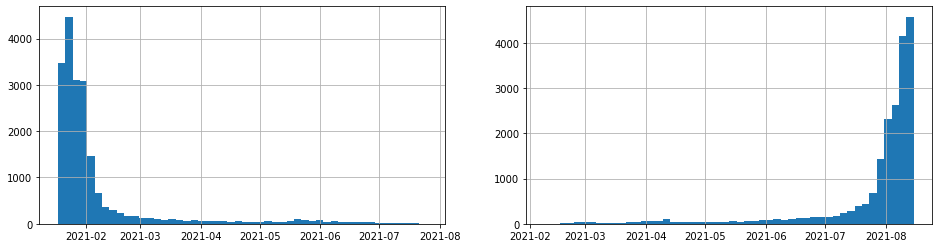

In [27]:
# Посмотрим на распределение времени начала и конца активности клиентов
plt.subplots(1,2, figsize = (16,4))
plt.subplot(1,2,1)
clickstream.groupby('user_id')['timestamp'].min().hist(bins=50)
plt.subplot(1,2,2)
clickstream.groupby('user_id')['timestamp'].max().hist(bins=50)

Подобраны клиенты, которые, в основном, были активны в течение всего временного интервала с середины января по середину августа 2021 года.

<AxesSubplot:>

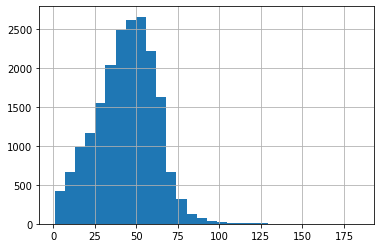

In [32]:
# Посмотрим на распределение количества уникальных категорий у каждого клиента
clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique).hist(bins=30)

Медианное количество уникальных категорий у каждого клиента - 45.

<AxesSubplot:>

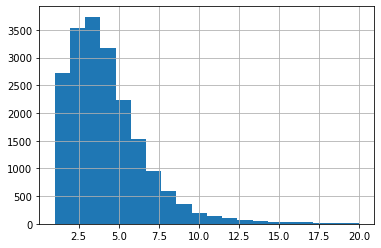

In [41]:
# Посмотрим на распределение количества уникальных устройств у каждого клиента
t = clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique)
t[t<21].hist(bins=20)

### 2. Transactions

In [44]:
%%time
transactions = pd.read_csv(f'{input_folder}/transactions.csv')

print('transactions memory usage: ', transactions.memory_usage().sum()//1024//1024, 'Mb')
print_memory()

transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])

transactions memory usage:  756 Mb
memory used 9.29 Gb | memory available 21.62 Gb | memory available 68.95 percent
CPU times: user 19.7 s, sys: 2.84 s, total: 22.6 s
Wall time: 59.6 s


In [45]:
print(transactions.shape)
transactions.head(2)

(19821910, 5)


,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40


In [46]:
for col in transactions:
    print(col, '\t', transactions[col].nunique(), '\t', transactions[col].min(), ' - ', transactions[col].max())

user_id 	 22533 	 000932580e404dafbecd5916d4640938  -  fffb051877b949f49bed6538393a06ae
mcc_code 	 386 	 -1  -  9406
currency_rk 	 4 	 -1  -  60
transaction_amt 	 17063000 	 -230044.03  -  346395.34
transaction_dttm 	 12787367 	 2020-07-17 18:59:38  -  2021-08-14 21:13:26


In [47]:
# Аналогично, чтобы уменьшить объём файла закодируем user_id числами
all_dicts['bank_le'] = LabelEncoder().fit(transactions['user_id'])
transactions['user_id'] = all_dicts['bank_le'].transform(transactions['user_id'])+1
transactions_dtypes = {'user_id':np.int16, 'mcc_code':np.int16, 'currency_rk':np.int8}
transactions = transactions.astype(transactions_dtypes)

print('transactions memory usage: ', transactions.memory_usage().sum()//1024//1024, 'Mb')
print_memory()

transactions memory usage:  396 Mb
memory used 8.3 Gb | memory available 22.61 Gb | memory available 72.11 percent


In [48]:
print ('На каждого клиента банка приходится ', round(transactions.shape[0] / transactions['user_id'].nunique(),1), 'уникальных записей')

На каждого клиента банка приходится  879.7 уникальных записей


<AxesSubplot:>

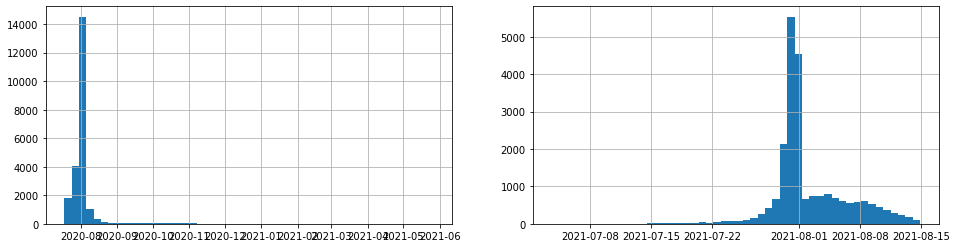

In [50]:
# Посмотрим на распределение времени начала и конца активности клиентов
plt.subplots(1,2, figsize = (16,4))
plt.subplot(1,2,1)
transactions.groupby('user_id')['transaction_dttm'].min().hist(bins=50)
plt.subplot(1,2,2)
transactions.groupby('user_id')['transaction_dttm'].max().hist(bins=50)

В основном, активность клиентов банка начинается в августе 2020 года и заканчивается в августе 2021.

In [51]:
# посмотрим на частоты валют
transactions.groupby('currency_rk')['user_id'].agg('count')

currency_rk
-1        27405
 48    19765158
 50       20364
 60        8983
Name: user_id, dtype: int64

Ожидаемо, почти все транзакции в одной валюте.

<AxesSubplot:>

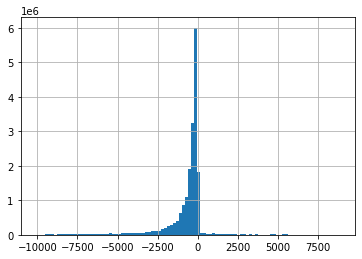

In [57]:
# Посмотрим на распределение transaction_amt
t_std = transactions['transaction_amt'].std()
t_mean = transactions['transaction_amt'].mean()
ind = (transactions['transaction_amt']>=t_mean-t_std)&(transactions['transaction_amt']<=t_mean+t_std)
transactions.loc[ind, 'transaction_amt'].hist(bins=100)

Заметим, что transaction_amt, в основном, отрицательное, так как это расходные операции.

<AxesSubplot:>

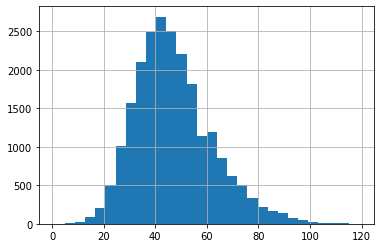

In [55]:
# Посмотрим на распределение количества уникальных категорий у каждого клиента
transactions.groupby('user_id')['mcc_code'].agg(pd.Series.nunique).hist(bins=30)

Также медианное значение количества уникальных категорий в районе 40.

### 3. Other files

#### 3.1 Click categories

In [58]:
click_categories = pd.read_csv('./data/click_categories.csv')
print(click_categories.shape)
click_categories.head(2)

(402, 4)


,cat_id,level_0,level_1,level_2
0,1,accessories,NaN,NaN
1,2,accessories,handbags,NaN


In [59]:
click_categories.fillna('', inplace=True)
for col in click_categories:
    print(col, '\t', click_categories[col].nunique(), '\t', click_categories[col].min(), ' - ', click_categories[col].max())

cat_id 	 402 	 1  -  1861
level_0 	 85 	 accessories  -  weather
level_1 	 280 	   -  work_gear
level_2 	 56 	   -  zoo


In [60]:
click_categories['level_0'].value_counts().head(5)

public_services    24
health             23
occupation         22
education          17
cars               15
Name: level_0, dtype: int64

In [61]:
click_categories['level_1'].value_counts().head(5)

                       81
school_education        6
household_services      6
business_automation     4
farming                 4
Name: level_1, dtype: int64

In [62]:
click_categories['level_2'].value_counts().head(5)

                    347
body_treatments       1
utilities_sector      1
orphanage             1
cigarettes            1
Name: level_2, dtype: int64

#### 3.2 MCC

In [63]:
mcc = pd.read_csv('./data/mcc_codes.csv')
print(mcc.shape)
mcc.head(5)

(385, 3)


,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."


#### 3.3 Currencies

In [64]:
currency = pd.read_csv('./data/currency_rk.csv')
print(currency.shape)
currency

(3, 2)


,currency_rk,Name
0,48,RUR
1,50,USD
2,60,EUR


#### 3.4 Sample puzzle submission, puzzle and train files

In [65]:
sub = pd.read_csv('./data/sample_submission.csv')
print(sub.shape)
sub.head(2)

(4952, 2)


,bank,rtk_list
0,6dd66e8624da427da6b558903a5772b8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,224a2325b44a4326bc539e3f1a6e713b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [66]:
puzzle = pd.read_csv('./data/puzzle.csv')
print(puzzle.shape)
puzzle.head(2)

(4952, 2)


,bank,rtk
0,6dd66e8624da427da6b558903a5772b8,56f386b1a1a9455b9118cd290b0627d7
1,224a2325b44a4326bc539e3f1a6e713b,ca77a88196ef4dd786fb390340cf226e


In [67]:
puzzle['bank'] = all_dicts['bank_le'].transform(puzzle['bank'])+1
puzzle['rtk'] = all_dicts['rtk_le'].transform(puzzle['rtk'])+1

In [68]:
train = pd.read_csv('./data/train_matching.csv')
print(train.shape)
train.head(2)

(17581, 2)


,bank,rtk
0,178b387813ac4a63a2200274a9e3876e,e19c0f141e9442c5bdb0d5751f6fba1c
1,47cffa46e6b04389ba91a70735d2c3ff,7df3371aabd349e4ac2de8299238627d


In [69]:
train['bank'] = all_dicts['bank_le'].transform(train['bank'])+1
train.loc[train.rtk=='0', 'rtk'] = 0
train.loc[train.rtk!=0, 'rtk'] = all_dicts['rtk_le'].transform(train.loc[train.rtk!=0, 'rtk'])+1

In [82]:
print('В файле train', train.bank.nunique(), 'клиентов банка, из которых', train.rtk.nunique(), 'имеют мэтчи с клиентами РТК.')

В файле train 17581 клиентов банка, из которых 14672 имеют мэтчи с клиентами РТК.


In [86]:
print('Всего в файле transactions.csv клиентов банка', transactions.user_id.nunique(), '=', puzzle.shape[0], '(задача puzzle) + ', train.bank.nunique(), '(файл train)')
print('Всего в файле clickstream.csv клиентов РТК', clickstream.user_id.nunique(), '=', puzzle.shape[0], '(задача puzzle) + ', train.rtk.nunique()-1, '(файл train)')

Всего в файле transactions.csv клиентов банка 22533 = 4952 (задача puzzle) +  17581 (файл train)
Всего в файле clickstream.csv клиентов РТК 19623 = 4952 (задача puzzle) +  14671 (файл train)


### 4. Сравнение активности смэтченных клиентов

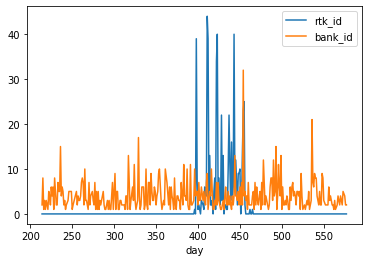

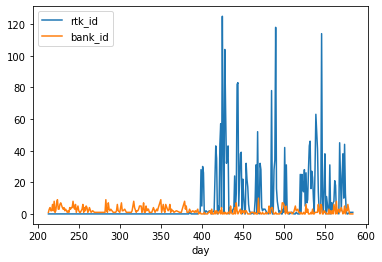

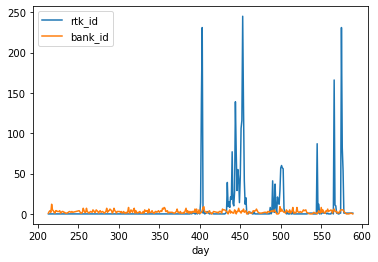

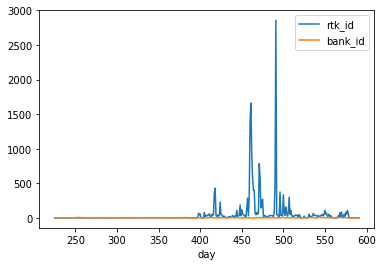

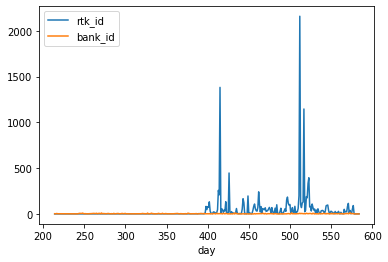

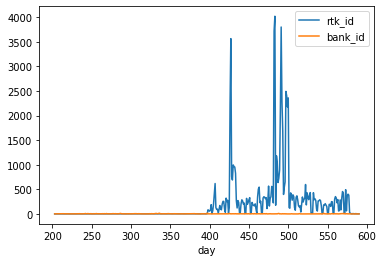

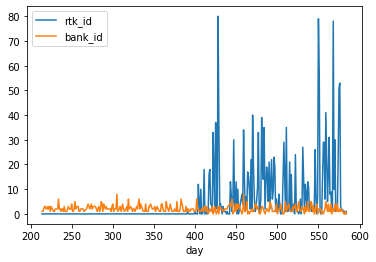

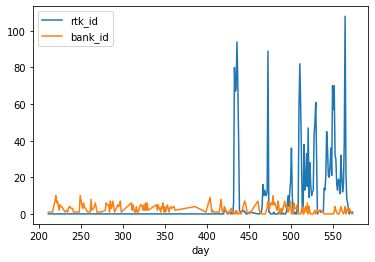

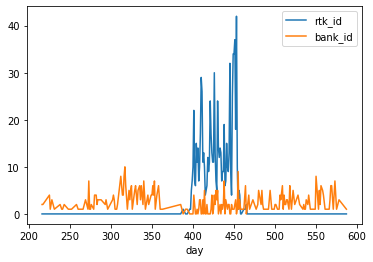

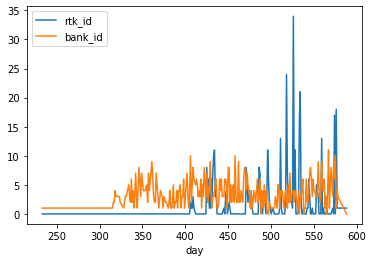

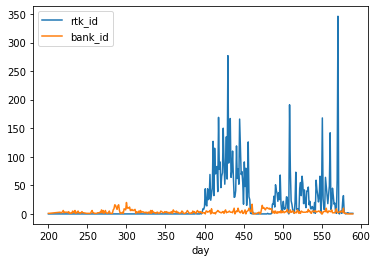

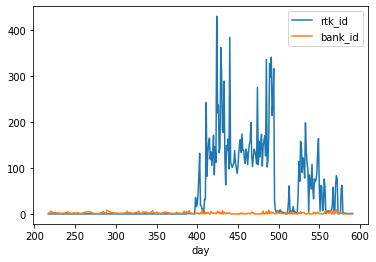

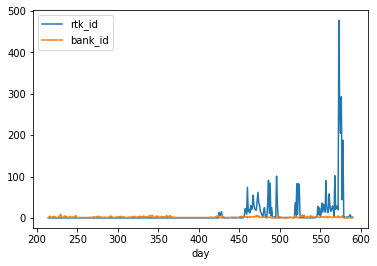

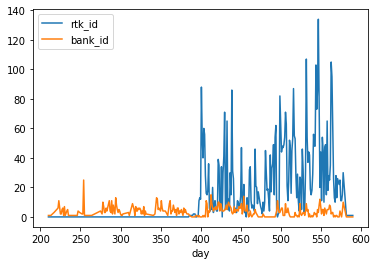

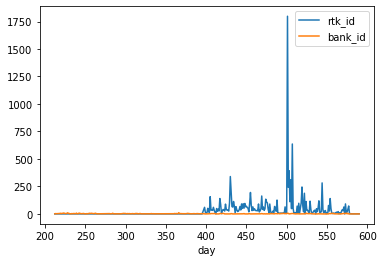

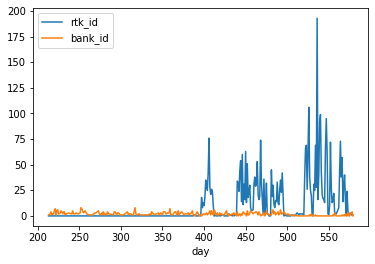

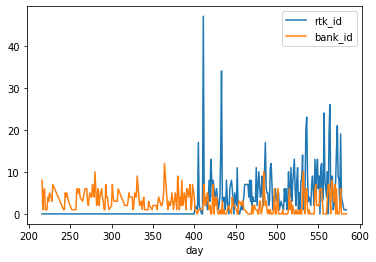

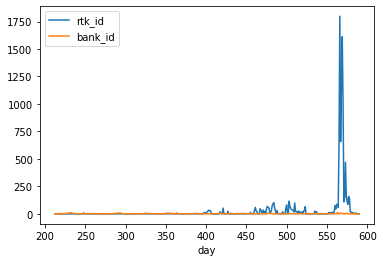

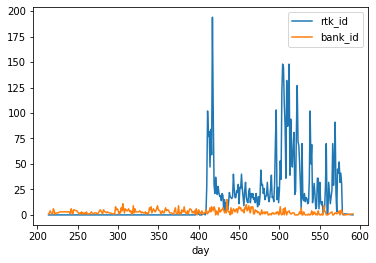

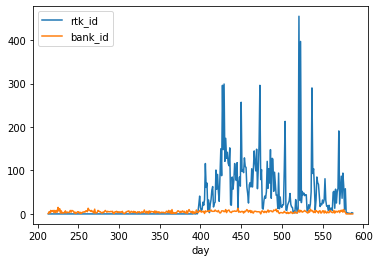

In [70]:
# посмотрим на активность смэтченных клиентов банка и ртк
for i in range(20):
    a = pd.concat([clickstream[clickstream.user_id==train.loc[i,'rtk']].rename({'user_id':'rtk_id'}, axis=1),
              transactions[transactions.user_id==train.loc[i,'bank']].rename({'transaction_dttm':'timestamp',
                                                                              'user_id':'bank_id'}, axis=1)],axis=0).sort_values('timestamp')
    a['day'] = a.timestamp.apply(lambda x: x.dayofyear+(x.year-2020)*366)
    a.groupby('day')[['rtk_id','bank_id']].agg('count').plot()

### 5. Catboost baseline training

#### 5.1 Сделаем эмбеддинги как предлагается в базовом решении

In [87]:
%%time
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                            values=['timestamp'],
                            columns=['cat_id'],
                            aggfunc=['count']).fillna(0)
clickstream_embed.columns = [f'rtk_{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]
clickstream_embed.loc[0] = np.empty(len(clickstream_embed.columns))
print_memory()
print('clickstream_embed memory usage: ', clickstream_embed.memory_usage().sum()//1024//1024, 'Mb')

memory used 8.95 Gb | memory available 21.96 Gb | memory available 70.02 percent
clickstream_embed memory usage:  60 Mb
CPU times: user 5.07 s, sys: 3.61 s, total: 8.68 s
Wall time: 8.68 s


In [88]:
del clickstream
gc.collect()
print_memory()

memory used 6.11 Gb | memory available 24.8 Gb | memory available 79.07 percent


In [89]:
%%time
bankclient_embed = transactions .pivot_table(index = 'user_id', 
                            values=['transaction_amt'],
                            columns=['mcc_code'],
                            aggfunc=['sum','mean', 'count']).fillna(0)
bankclient_embed.columns = [f'bank_{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]
print_memory()
print('bankclient_embed memory usage: ', bankclient_embed.memory_usage().sum()//1024//1024, 'Mb')

memory used 6.12 Gb | memory available 24.79 Gb | memory available 79.04 percent
bankclient_embed memory usage:  199 Mb
CPU times: user 3.9 s, sys: 832 ms, total: 4.73 s
Wall time: 4.74 s


In [90]:
del transactions
gc.collect()
print_memory()

memory used 5.83 Gb | memory available 25.08 Gb | memory available 79.98 percent


In [91]:
print(bankclient_embed.shape, clickstream_embed.shape)
full_list_of_features = clickstream_embed.columns.tolist() + bankclient_embed.columns.tolist()
print(len(full_list_of_features))

(22533, 1158) (19624, 402)
1560


In [92]:
with open("./full_list_of_features_baseline", "wb") as fp:   # Pickling
     pickle.dump(full_list_of_features, fp)

In [93]:
bankclient_embed.fillna(0, inplace=True)
clickstream_embed.fillna(0, inplace=True)

In [94]:
print(bankclient_embed.memory_usage().sum()/1024/1024, 'Mb', clickstream_embed.memory_usage().sum()/1024/1024, 'Mb')
dtype = pd.SparseDtype(np.int32, fill_value=0)
bankclient_embed = bankclient_embed.astype(dtype)
clickstream_embed = clickstream_embed.astype(dtype)
print(bankclient_embed.memory_usage().sum()/1024/1024, 'Mb', clickstream_embed.memory_usage().sum()/1024/1024, 'Mb')

199.2473373413086 Mb 60.33685302734375 Mb
24.50006103515625 Mb 6.69207763671875 Mb


#### 5.2 Training

In [95]:
# Перемешаем уникальных user_id клиентов банка 
bank_ids_shuffled = train['bank'].sample(n=train.shape[0], replace=False, random_state=36)
# Отделим одну шестую для валидации (примерно соответствует размеру public/private в первой задаче)
s = len(bank_ids_shuffled)//6
print(len(bank_ids_shuffled), s)

17581 2930


In [96]:
# Соберём обучающую выборку, где на 1 правильный мэтч будет приходиться 10 неправильных

k=10
cor_dict = train.set_index('bank')['rtk'].to_dict()

train_bank_ids = train[(train.bank.isin(bank_ids_shuffled[:-s]))&(train.rtk!=0)]['bank']
train_rtk_ids = train[train.bank.isin(train_bank_ids)]['rtk'].drop_duplicates()
df_train = pd.DataFrame(train_bank_ids, columns=['bank'])
df_train['rtk'] = df_train['bank'].apply(lambda x: [cor_dict[x]] + train_rtk_ids.sample(k, random_state=x).values.tolist() )

valid_bank_ids = train[(train.bank.isin(bank_ids_shuffled[-s:]))&(train.rtk!=0)]['bank']
valid_rtk_ids = train[train.bank.isin(valid_bank_ids)]['rtk'].drop_duplicates()
df_valid = pd.DataFrame(valid_bank_ids, columns=['bank'])
df_valid['rtk'] = df_valid['bank'].apply(lambda x: valid_rtk_ids.values.tolist())

df_train = df_train.explode('rtk')
df_valid = df_valid.explode('rtk')

train['bank+rtk'] = train['bank'].astype('str')+'_'+train['rtk'].astype('str')
df_train['bank+rtk'] = df_train['bank'].astype('str')+'_'+df_train['rtk'].astype('str')
df_valid['bank+rtk'] = df_valid['bank'].astype('str')+'_'+df_valid['rtk'].astype('str')
df_train['target'] = df_train['bank+rtk'].isin(train['bank+rtk']).astype('int')
df_valid['target'] = df_valid['bank+rtk'].isin(train['bank+rtk']).astype('int')

df_train.drop_duplicates('bank+rtk', inplace=True)
df_valid.drop_duplicates('bank+rtk', inplace=True)

df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

In [97]:
print(df_train.shape, df_valid.shape, df_train['target'].mean(), df_valid['target'].mean())
print(df_train.bank.nunique(), df_train.rtk.nunique(), df_train['bank+rtk'].nunique())
print(df_valid.bank.nunique(), df_valid.rtk.nunique(), df_valid['bank+rtk'].nunique())

(134271, 4) (6066369, 4) 0.09092060087435112 0.0004060089321965083
12208 12208 134271
2463 2463 6066369


In [98]:
# Посмотрим параметры модели, обученной организаторами
old_model = CatBoostClassifier()
old_model.load_model('./baseline_catboost/model.cbm',  format='cbm')
print(old_model.get_all_params())
print(old_model.best_iteration_, old_model.best_score_, old_model.get_best_score())

{'nan_mode': 'Min', 'eval_metric': 'MRR', 'iterations': 2000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.1000000015, 'l2_leaf_reg': 3, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.8000000119, 'use_best_model': True, 'od_wait': 100, 'random_seed': 0, 'depth': 4, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'CrossEntropy', 'learning_rate': 0.02999999933, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iteration

2000 итераций, 0.03 learning rate

In [100]:
clf = CatBoostClassifier()
clf.set_params(**old_model.get_all_params())
clf.set_params(**{'eval_metric':'Logloss'})
clf.set_params(**{'use_best_model': False})

df_train['predicts'] = 0
df_valid['predicts'] = 0

X_train=df_train.merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
Y_train=df_train['target']
    
for j in full_list_of_features:
    if j not in X_train.columns:
        X_train[j] = 0
            
X_train = X_train[full_list_of_features].values
    
print(X_train.shape)

clf.fit(X_train, Y_train, verbose=10) 
clf.save_model('model_baseline.cbm')
print()
    
df_train['predicts'] = clf.predict_proba(X_train)[:,1]
n = 100
    
train_preds = df_train.loc[:, ['predicts','target', 'bank', 'rtk']].copy(deep=True)
train_preds['pred_rank'] = train_preds.groupby('bank')['predicts'].rank(ascending=False)
precision_train = train_preds[train_preds.pred_rank<=n]['target'].sum()/train_preds.bank.nunique()
mrr_train = 1/train_preds[(train_preds.pred_rank<=n)]['pred_rank']*train_preds[(train_preds.pred_rank<=n)]['target']
mrr_train = mrr_train.sum()/train_preds.bank.nunique()
hm_train = 2/(1/precision_train+1/mrr_train)
print('Train harmonic mean ', round(hm_train,6), ' | mrr ', round(mrr_train,6),' | precision ', round(precision_train,6))
    
del X_train

(134271, 1560)
0:	learn: 0.6654870	total: 181ms	remaining: 6m 2s
10:	learn: 0.4777680	total: 923ms	remaining: 2m 46s
20:	learn: 0.3892713	total: 1.63s	remaining: 2m 33s
30:	learn: 0.3469744	total: 2.43s	remaining: 2m 34s
40:	learn: 0.3262517	total: 3.21s	remaining: 2m 33s
50:	learn: 0.3157550	total: 3.95s	remaining: 2m 30s
60:	learn: 0.3104252	total: 4.73s	remaining: 2m 30s
70:	learn: 0.3076135	total: 5.5s	remaining: 2m 29s
80:	learn: 0.3059627	total: 6.32s	remaining: 2m 29s
90:	learn: 0.3051923	total: 7.1s	remaining: 2m 29s
100:	learn: 0.3046688	total: 7.9s	remaining: 2m 28s
110:	learn: 0.3040686	total: 8.8s	remaining: 2m 29s
120:	learn: 0.3034492	total: 9.71s	remaining: 2m 30s
130:	learn: 0.3030891	total: 10.5s	remaining: 2m 30s
140:	learn: 0.3027957	total: 11.4s	remaining: 2m 30s
150:	learn: 0.3024269	total: 12.2s	remaining: 2m 29s
160:	learn: 0.3020594	total: 13.1s	remaining: 2m 30s
170:	learn: 0.3015627	total: 14.1s	remaining: 2m 30s
180:	learn: 0.3012663	total: 14.9s	remaining: 2

1540:	learn: 0.2779988	total: 2m 13s	remaining: 39.7s
1550:	learn: 0.2778974	total: 2m 14s	remaining: 38.8s
1560:	learn: 0.2777958	total: 2m 14s	remaining: 37.9s
1570:	learn: 0.2776924	total: 2m 15s	remaining: 37.1s
1580:	learn: 0.2775238	total: 2m 16s	remaining: 36.2s
1590:	learn: 0.2774032	total: 2m 17s	remaining: 35.4s
1600:	learn: 0.2773307	total: 2m 18s	remaining: 34.5s
1610:	learn: 0.2772343	total: 2m 19s	remaining: 33.6s
1620:	learn: 0.2771195	total: 2m 20s	remaining: 32.7s
1630:	learn: 0.2770363	total: 2m 20s	remaining: 31.9s
1640:	learn: 0.2769328	total: 2m 21s	remaining: 31s
1650:	learn: 0.2768394	total: 2m 22s	remaining: 30.1s
1660:	learn: 0.2767463	total: 2m 23s	remaining: 29.3s
1670:	learn: 0.2766651	total: 2m 24s	remaining: 28.4s
1680:	learn: 0.2765815	total: 2m 25s	remaining: 27.5s
1690:	learn: 0.2764937	total: 2m 25s	remaining: 26.7s
1700:	learn: 0.2763960	total: 2m 26s	remaining: 25.8s
1710:	learn: 0.2763121	total: 2m 27s	remaining: 24.9s
1720:	learn: 0.2761954	total: 

In [101]:
# самые полезные фичи
pd.DataFrame({'col':full_list_of_features, 'imp':clf.get_feature_importance()}).sort_values('imp', ascending=False).head(20)

,col,imp
208,rtk_count-772,6.135850
83,rtk_count-289,2.465118
185,rtk_count-592,2.166608
25,rtk_count-68,1.998854
999,bank_mean-5735,1.978487
128,rtk_count-437,1.840128
41,rtk_count-153,1.695610
169,rtk_count-535,1.598767
87,rtk_count-308,1.408853
902,bank_mean-4121,1.403153


In [102]:
# треть фич не использовалась
(clf.get_feature_importance()==0).sum()

529

##### 5.3 Валидация на всех валидационных клиентах банка и ртк

In [103]:
valid_bank_ids = train[(train.bank.isin(bank_ids_shuffled[-s:]))]['bank']
valid_rtk_ids = train[(train.bank.isin(valid_bank_ids))&(train.rtk!=0)]['rtk'].drop_duplicates()
df_valid = pd.DataFrame(valid_bank_ids, columns=['bank'])
df_valid['rtk'] = df_valid['bank'].apply(lambda x: valid_rtk_ids.values.tolist())

df_valid = df_valid.explode('rtk')

df_valid['bank+rtk'] = df_valid['bank'].astype('str')+'_'+df_valid['rtk'].astype('str')
df_valid['target'] = df_valid['bank+rtk'].isin(train['bank+rtk']).astype('int')

df_valid.drop_duplicates('bank+rtk', inplace=True)

df_valid.reset_index(inplace=True, drop=True)

print(df_valid.bank.nunique(), df_valid.rtk.nunique(), df_valid['bank+rtk'].nunique())

2930 2463 7216590


In [104]:
%%time
batch = 200
for i in range(len(valid_bank_ids)//batch+1):
    print(i, end=' ')
    bank_batch = valid_bank_ids[i*batch:(i+1)*batch]
    X_valid=df_valid[df_valid.bank.isin(bank_batch)].merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
    X_valid = X_valid[full_list_of_features].values
    df_valid.loc[df_valid.bank.isin(bank_batch), 'predicts'] = clf.predict_proba(X_valid)[:,1]
    del X_valid
    
zeros_part = pd.DataFrame({'bank':valid_bank_ids, 'rtk':[0]*len(valid_bank_ids), 'predicts':[5]*len(valid_bank_ids)})
zeros_part['bank+rtk'] = zeros_part['bank'].astype('str')+'_'+zeros_part['rtk'].astype('str')

df_valid = pd.concat([df_valid, zeros_part], axis=0).reset_index(drop=True)
df_valid['target'] = df_valid['bank+rtk'].isin(train['bank+rtk']).astype('int')

df_valid['pred_rank'] = df_valid.groupby('bank')['predicts'].rank(ascending=False)
precision_valid = df_valid[df_valid.pred_rank<=n]['target'].sum()/df_valid.bank.nunique()
mrr_valid = 1/df_valid[(df_valid.pred_rank<=n)]['pred_rank']*df_valid[(df_valid.pred_rank<=n)]['target']
mrr_valid = mrr_valid.sum()/df_valid.bank.nunique()
hm_valid = 2/(1/precision_valid+1/mrr_valid)

print()
print('Task 1 Valid harmonic mean ', round(hm_valid,6), ' | mrr ', round(mrr_valid,6),' | precision ', round(precision_valid,6))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Task 1 Valid harmonic mean  0.224875  | mrr  0.171651  | precision  0.325939
CPU times: user 8min 42s, sys: 19.4 s, total: 9min 1s
Wall time: 7min 58s


In [105]:
# проверяем только для тех, у кого есть мэтчи и без учёта предсказания 0 в качестве наиболее вероятного мэтча

valid_bank_ids = train[(train.bank.isin(bank_ids_shuffled[-s:]))&(train.rtk!=0)]['bank']

ind = (df_valid.pred_rank<=n+1)&(df_valid.pred_rank>1)&(df_valid.bank.isin(valid_bank_ids))
precision_valid = df_valid[ind]['target'].sum()/df_valid.rtk.nunique()
mrr_valid = 1/(df_valid[ind]['pred_rank']-1)*df_valid[ind]['target']
mrr_valid = mrr_valid.sum()/df_valid.rtk.nunique()
hm_valid = 2/(1/precision_valid+1/mrr_valid)

print()
print('Task 2 Valid harmonic mean ', round(hm_valid,6), ' | mrr ', round(mrr_valid,6),' | precision ', round(precision_valid,6))


Task 2 Valid harmonic mean  0.036856  | mrr  0.020306  | precision  0.199269


Метрики для второй задачи несколько завышены, так как в задаче puzzle примерно в 2 раза больше клиентов, то есть сложнее найти пару.

#### 5.4 Puzzle inference

In [106]:
puzzle_bank_ids = puzzle['bank'].drop_duplicates()
puzzle_rtk_ids = puzzle['rtk'].drop_duplicates()
df_puzzle = pd.DataFrame(puzzle_bank_ids, columns=['bank'])
df_puzzle['rtk'] = df_puzzle['bank'].apply(lambda x: puzzle_rtk_ids.values.tolist())

df_puzzle = df_puzzle.explode('rtk')

df_puzzle.reset_index(inplace=True, drop=True)

In [107]:
print(df_puzzle.shape, len(puzzle_bank_ids), len(puzzle_rtk_ids))

(24522304, 2) 4952 4952


In [108]:
%%time
batch = 200
for i in range(len(puzzle_bank_ids)//batch+1):
    print(i, end=' ')
    bank_batch = puzzle_bank_ids[i*batch:(i+1)*batch]
    X_puzzle=df_puzzle[df_puzzle.bank.isin(bank_batch)].merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
    X_puzzle = X_puzzle[full_list_of_features].values
    df_puzzle.loc[df_puzzle.bank.isin(bank_batch), 'predicts'] = clf.predict_proba(X_puzzle)[:,1]
    del X_puzzle
    
df_puzzle['pred_rank'] = df_puzzle.groupby('bank')['predicts'].rank(ascending=False)

print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
CPU times: user 30min 30s, sys: 1min 6s, total: 31min 37s
Wall time: 28min 3s


In [109]:
df_puzzle[df_puzzle.pred_rank<=100]['bank'].value_counts().value_counts()
## там где 99 хорошо бы добавить на всякий случай !!!!

100    4945
99        7
Name: bank, dtype: int64

In [110]:
sub = df_puzzle[df_puzzle.pred_rank<=100].copy(deep=True)
sub['rtk'] = all_dicts['rtk_le'].inverse_transform(sub['rtk'].astype(int)-1)
sub['bank'] = all_dicts['bank_le'].inverse_transform(sub['bank']-1)

sub = sub.pivot_table(index='bank', values='rtk', aggfunc=list)
sub['rtk'] = sub['rtk'].apply(lambda x: str(x))
sub = sub.replace("'", '', regex=True)
sub.rename({'rtk':'rtk_list'}, axis=1).to_csv('sub_puzzle_baseline.csv', index=True)